In [1]:
import numpy as np
import h5py
import math

from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv3D
from keras.layers import Lambda, Concatenate, MaxPooling2D, Maximum, Add
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from keras.losses import MeanSquaredError
from keras.callbacks import Callback,LearningRateScheduler
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

In [2]:
# Load Dataset from Google Drive
def load_train_dataset():
    """
    Load training dataset from Google Drive
    
    Returns:
    clean_image -- Clean image patches
    clean_image -- Hazy image patches
    transmission_value -- Transmission value which convert clean image to 
                          haze image
    """

    file = '../../dataset/dehaze.hdf5'
    train_dataset = h5py.File(file, 'r')
    clean_image = np.array(train_dataset['clear_image'][:])
    haze_image = np.array(train_dataset['hazy_image'][:])
    # transmission_map = np.array(train_dataset['transmission_map'])
    transmission_map_refine = np.array(train_dataset['transmission_map_refined'])
    
    return clean_image, haze_image, transmission_map_refine


# Gaussian Weight Initializtion for layers
weight_init = RandomNormal(mean=0.0, stddev=0.001)


# LearningRate Decay function
def lr_schedule(epoch,lr, logs={}):
    """
    Learning Rate Deacy scheduler

    Arguments:
    epoch -- current epoch number
    lr -- current learning rate
    log -- dictionary storing the logs of training

    Returns:
    lr -- learning rate for next epoch
    """
    
    print('learning_rate:',lr)
    logs.update({'lr': lr})
    if epoch in (49,99):
        return lr*0.5
    else:
        return lr

In [3]:
clean_image, haze_image, transmission_map_refine = load_train_dataset()

print ("Number of training examples:", clean_image.shape[0])
print ("Clean Image Patch shape:", clean_image.shape)
print ("Haze Image Patch shape:", haze_image.shape)
print ("Transmission Map Refine shape:", haze_image.shape)

Number of training examples: 956
Clean Image Patch shape: (956, 512, 512, 3)
Haze Image Patch shape: (956, 512, 512, 3)
Transmission Map Refine shape: (956, 512, 512, 3)


In [4]:
residual_input = np.clip(((haze_image/255.0)/np.expand_dims(transmission_map_refine,axis=3)),0,1)
residual_output = np.clip((residual_input-clean_image),0,1)

In [5]:
del clean_image, haze_image, transmission_map_refine

In [6]:
def ResidualBlock(X, iter):
    """
    Implementation of the single block of RNN
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    iter -- integer, used to name layers, depending on current residual block
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Save the input value
    X_shortcut = X
    
    # BATCHNORMALIZATION -> CONV Block
    X = BatchNormalization(axis = 3, name = 'res_batchnorm_' + str(iter))(X)
    X = Conv2D(1, (3, 3), strides = (1,1), padding = 'same', kernel_initializer = weight_init, name = 'res_conv_' + str(iter))(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add(name = 'res_add_'+ str(iter))([X,X_shortcut])
    X = Activation('relu', name = 'res_activation_'+ str(iter))(X)
    
    return X

def ResidualModel(input_shape):
    """
    Implementation of the Model.
    
    Arguments:
    input_shape -- shape of the images of the dataset 
                   (height, width, channels) as a tuple.  

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape, name = 'input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv1')(X_input)
    X = Activation('relu', name = 'activation1')(X)

    # X = Conv2D(8, (1, 1), kernel_initializer = weight_init, name='test_conv')(X)

    for i in range(17):
        X = ResidualBlock(X, i)
    
    # CONV BLock
    X = Conv2D(3, (3, 3), strides = (1, 1), padding = 'same', kernel_initializer = weight_init, name = 'conv2')(X)
    X = Activation('relu', name = 'activation2')(X)

    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name='TransmissionModel')

    return model

In [8]:
import tensorflow as tf

model2 = ResidualModel(residual_input.shape[1:])
model2.summary()
optimizer = tf.keras.optimizers.legacy.SGD(0.001)
model2.compile(optimizer=optimizer, loss=MeanSquaredError())

2024-01-05 20:07:10.887505: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-01-05 20:07:10.887704: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-01-05 20:07:10.887720: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-01-05 20:07:10.887750: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-05 20:07:10.887984: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and 

Model: "TransmissionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 512, 512, 16)         448       ['input1[0][0]']              
                                                                                                  
 activation1 (Activation)    (None, 512, 512, 16)         0         ['conv1[0][0]']               
                                                                                                  
 res_batchnorm_0 (BatchNorm  (None, 512, 512, 16)         64        ['activation1[0][0]']         
 alization)                                                                       

In [9]:
history2 = model2.fit(residual_input, residual_output, batch_size = 30, epochs = 4, callbacks=[LearningRateScheduler(lr_schedule)])

learning_rate: 0.0010000000474974513
Epoch 1/4


2024-01-05 20:07:21.856789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 202s 6s/step - loss: 0.0055 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 2/4
32/32 [==============================] - 205s 6s/step - loss: 0.0055 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 3/4
32/32 [==============================] - 200s 6s/step - loss: 0.0055 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 4/4
32/32 [==============================] - 198s 6s/step - loss: 0.0055 - lr: 0.0010


In [10]:
model2.save('resnet.keras')

In [23]:
from PIL.Image import Image
img = np.array(residual_input[0])
img = img.reshape((1, 512, 512, 3))
img.shape
out = model2.predict(img)

1/1 [==============================] - 1s 697ms/step


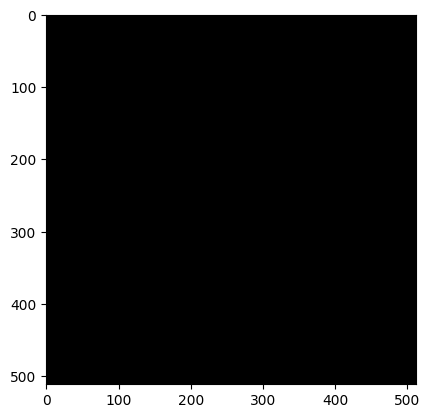

In [26]:
out.shape
plt.imshow(out.reshape(512, 512, 3))

In [27]:
out

array([[[[2.1305557e-04, 6.2231047e-05, 1.0888168e-03],
         [2.3796983e-04, 6.6513123e-05, 1.0973676e-03],
         [2.3435969e-04, 5.3356744e-05, 1.0899751e-03],
         ...,
         [2.2265353e-04, 7.9849109e-05, 1.0956901e-03],
         [2.2319461e-04, 9.4081915e-05, 1.1001643e-03],
         [2.6346149e-04, 6.5351516e-05, 1.0914867e-03]],

        [[2.0691217e-04, 6.0036968e-05, 1.0964667e-03],
         [2.3421724e-04, 6.7026529e-05, 1.1072933e-03],
         [2.2407547e-04, 6.7142450e-05, 1.1044466e-03],
         ...,
         [2.0986301e-04, 9.7225377e-05, 1.1212138e-03],
         [2.0485674e-04, 1.0825442e-04, 1.1164899e-03],
         [2.6403985e-04, 8.5675609e-05, 1.1016809e-03]],

        [[2.0767855e-04, 6.0520215e-05, 1.0918610e-03],
         [2.2440817e-04, 7.4931406e-05, 1.1102215e-03],
         [2.1055977e-04, 7.5259624e-05, 1.1085307e-03],
         ...,
         [1.9921677e-04, 1.0353438e-04, 1.1205450e-03],
         [1.9570952e-04, 1.1476068e-04, 1.1151721e-03],
  

In [31]:
# Assuming 'residual_input' and 'predicted_residuals' have the same shape (512, 512, 3)
predicted_residuals = model2.predict(img)

# Reconstruct the clean image
predicted_clean_image = np.clip(img + predicted_residuals, 0, 1)


1/1 [==============================] - 0s 39ms/step


In [32]:
predicted_clean_image

array([[[[0.79586072, 0.80094442, 0.74962576],
         [0.65436198, 0.65938198, 0.60849823],
         [0.63274395, 0.63774745, 0.58693902],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[0.83987389, 0.84497493, 0.79353217],
         [0.71938638, 0.72443044, 0.67335823],
         [0.50978822, 0.5147784 , 0.46434458],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 0.96841586]],

        [[0.7411768 , 0.74624773, 0.69509815],
         [0.80140303, 0.80649002, 0.75516069],
         [0.58976445, 0.59480068, 0.54411869],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

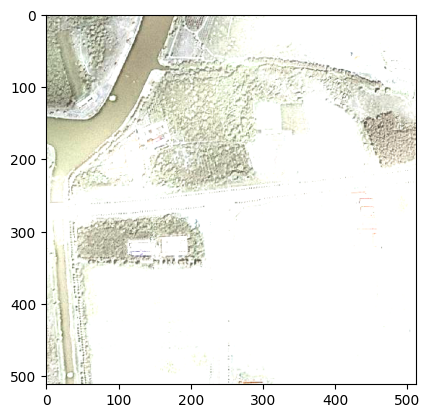

In [35]:
plt.imshow(predicted_clean_image.reshape((512, 512, 3)))

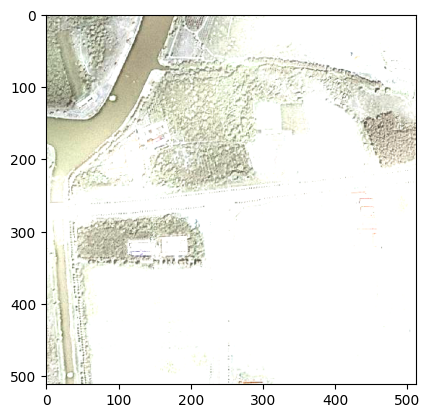

In [36]:
plt.imshow(img.reshape((512, 512, 3)))